# Multimodal single cell CITE-seq CBMC example

A python adaptation of the Seurat multimodal vignette: https://satijalab.org/seurat/articles/multimodal_vignette.html

## Download CITE-seq data

The dataset contains 8,617 cord blood mononuclear cells (CBMCs),  where transcriptomic measurements are paired with abundance estimates for 11 surface proteins, whose levels are quantified with DNA-barcoded antibodies. Two count matrix files must be downloaded: one for the RNA measurements, and one for the antibody-derived tags (ADT).

In [1]:
# downloading the RNA count matrix file --> GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz
#!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz

# downloading the ADT count matrix file --> GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz
#!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz

## Install and import packages

In [ ]:
#!pip install -q numpy
#!pip install -q scipy
#!pip install -q pandas
#!pip install -q lightgbm
#!pip install -q tensorflow
#!pip install -q scikit-learn
#!pip install -q seaborn
#!pip install -q matplotlib
#!pip install -q tqdm
#!pip install -q scanpy
#!pip install -q episcanpy
#!pip install -q anndata

In [2]:
import numpy as np
import scipy
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import scanpy as sc
import episcanpy as epi
import anndata as ad 

np.random.seed(69420)
tf.random.set_seed(69420)

## Load matrix count files

Create AnnData objects out of the RNA and ADT count matrices. UMI CSV files are first read in as Pandas dataframes and then loaded into AnnData objects.

In [3]:
# a python version of Seurat's function: https://satijalab.org/seurat/reference/collapsespeciesexpressionmatrix

def CollapseSpeciesExpressionMatrix(df_rna, prefix='HUMAN_', control_prefix='MOUSE_', n_controls=100):
    features = np.array([prefix in x for x in df_rna.index.values])
    controls = np.array([control_prefix in x for x in df_rna.index.values])
    others = ~ (features | controls)
    
    df_rna_features = df_rna[features]
    df_rna_controls = df_rna[controls]
    df_rna_others = df_rna[others]
    
    df_rna_controls['rowsum'] = df_rna_controls.sum(axis=1)
    df_rna_controls = df_rna_controls.sort_values(by='rowsum', ascending=False)
    df_rna_controls = df_rna_controls.head(100).drop('rowsum', axis=1)
    
    df_rna_features = df_rna_features.set_index(np.array([x[6:] for x in df_rna_features.index.values]))
    
    df_rna = pd.concat([df_rna_features, df_rna_controls, df_rna_others])
    return df_rna

In [4]:
# parse the downloaded UMI CSV files into pandas dataframes

cbmc_rna = pd.read_csv('GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz', sep=',', header=0, index_col=0)
cbmc_rna = CollapseSpeciesExpressionMatrix(cbmc_rna)
cbmc_adt = pd.read_csv('GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz', sep=',', header=0, index_col=0)
print(np.all(cbmc_rna.columns == cbmc_adt.columns))

cbmc_rna = cbmc_rna.T
cbmc_adt = cbmc_adt.T

n_proteins = len(cbmc_adt.columns)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True


In [5]:
cbmc_rna

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,MOUSE_Ppp1ca,MOUSE_Cald1,MOUSE_Rps26,MOUSE_Ctsl,MOUSE_Tnfrsf12a,MOUSE_Esd,MOUSE_Acta2,MOUSE_Arpc2,MOUSE_Calr,ERCC_ERCC-00104
CTGTTTACACCGCTAG,0,0,0,0,0,0,0,0,0,0,...,38,161,22,133,57,58,5,66,21,0
CTCTACGGTGTGGCTC,0,0,0,0,0,0,0,0,0,0,...,67,85,60,77,55,70,69,52,33,0
AGCAGCCAGGCTCATT,0,0,0,0,0,0,0,0,0,0,...,69,87,60,112,74,37,27,68,76,0
GAATAAGAGATCCCAT,0,0,0,0,0,0,0,0,0,0,...,71,87,84,67,44,80,31,62,107,0
GTGCATAGTCATGCAT,0,0,0,0,0,0,0,0,0,0,...,88,128,58,23,29,13,547,93,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCGTGTAGATTAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
GGCGTGTAGTGTACTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
CGTATGCCGTCTTCTG,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
TACACGACGCTCTTCC,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,1,1,2,2,0,0


In [6]:
cbmc_adt

,CD3,CD4,CD8,CD45RA,CD56,CD16,CD10,CD11c,CD14,CD19,CD34,CCR5,CCR7
CTGTTTACACCGCTAG,60,72,76,575,64,161,156,77,206,70,179,99,104
CTCTACGGTGTGGCTC,52,49,59,3943,68,107,95,65,129,665,79,101,72
AGCAGCCAGGCTCATT,89,112,61,682,87,117,113,65,169,79,78,85,80
GAATAAGAGATCCCAT,55,66,56,378,58,82,66,44,136,49,83,60,46
GTGCATAGTCATGCAT,63,80,94,644,104,168,129,92,164,81,152,110,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCGTGTAGATTAG,6,42,8,67,16,9,6,267,124,5,2,6,12
GGCGTGTAGTGTACTC,14,40,17,150,14,29,13,136,196,10,11,28,11
CGTATGCCGTCTTCTG,7,8,3,36,3,3,5,4,12,2,1,0,4
TACACGACGCTCTTCC,18,16,20,129,10,25,20,8,18,12,7,9,6


In [7]:
# read the dataframes into AnnData objects

adata_cbmc_rna = ad.AnnData(X=cbmc_rna)
adata_cbmc_adt = ad.AnnData(X=cbmc_adt)

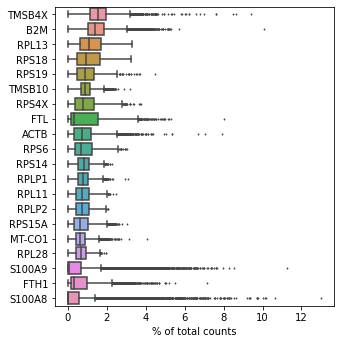

In [8]:
# display the highest expressed genes
sc.pl.highest_expr_genes(adata_cbmc_rna, n_top=20)

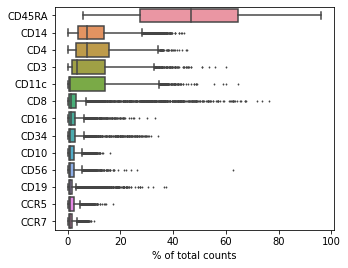

In [9]:
# display the relative abundance of proteins
sc.pl.highest_expr_genes(adata_cbmc_adt, n_top=13, )

## Preprocessing

The steps below represent a quick exploratory data analysis and clustering of the CBMCs based on the scRNA-seq data.

In [10]:
# copy raw RNA counts data
adata_cbmc_rna.layers['counts'] = adata_cbmc_rna.X.copy()

In [11]:
# normalize RNA counts data
sc.pp.normalize_total(adata_cbmc_rna)
sc.pp.log1p(adata_cbmc_rna)

In [12]:
# dimensionality reduction and clustering on RNA counts data
sc.pp.pca(adata_cbmc_rna)
sc.pp.neighbors(adata_cbmc_rna, n_neighbors=30)
sc.tl.umap(adata_cbmc_rna)
sc.tl.leiden(adata_cbmc_rna, key_added='rna_leiden')

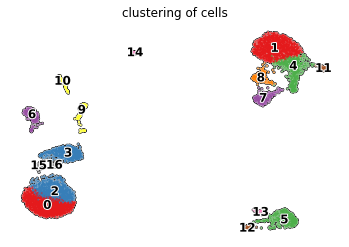

In [13]:
# plot UMAP on RNA data
sc.pl.umap(adata_cbmc_rna, color='rna_leiden', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [14]:
# copy raw protein counts data
adata_cbmc_adt.layers['counts'] = adata_cbmc_adt.X.copy()

In [15]:
# python version of CLR normalization from Seurat: https://satijalab.org/seurat/reference/normalizedata

# the original code can be found here: https://github.com/theislab/scanpy/issues/1208

def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [16]:
# normalize ADT counts data
clr_normalize_each_cell(adata_cbmc_adt)
sc.pp.log1p(adata_cbmc_adt)

In [17]:
# dimensionality reduction and clustering on ADT counts data
sc.pp.pca(adata_cbmc_adt, n_comps=6)
sc.pp.neighbors(adata_cbmc_adt, n_neighbors=30)  # why can't we just work with the default neighbors?
sc.tl.leiden(adata_cbmc_adt, key_added="protein_leiden")
adata_cbmc_adt.obsp["protein_connectivities"] = adata_cbmc_adt.obsp["connectivities"].copy()
sc.tl.umap(adata_cbmc_adt)

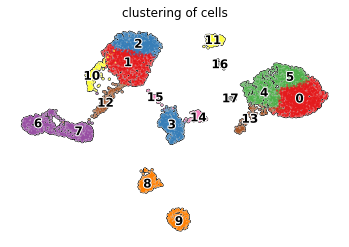

In [19]:
# plot UMAP on ADT data
sc.pl.umap(adata_cbmc_adt, color='protein_leiden', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [20]:
# copy some ADT calculations to RNA AnnData object to allow plotting
adata_cbmc_rna.obsm["protein"] = adata_cbmc_adt.to_df()
adata_cbmc_rna.obsm["protein_umap"] = adata_cbmc_adt.obsm["X_umap"]
adata_cbmc_rna.obs["protein_leiden"] = adata_cbmc_adt.obs["protein_leiden"]
adata_cbmc_rna.obsp["rna_connectivities"] = adata_cbmc_rna.obsp["connectivities"].copy()
adata_cbmc_rna.obsp["protein_connectivities"] = adata_cbmc_adt.obsp["protein_connectivities"]
adata_cbmc_rna.obs['CD19_protein'] = adata_cbmc_rna.obsm["protein"]['CD19']

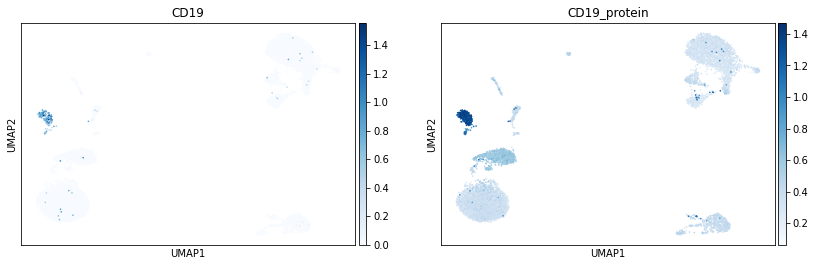

In [21]:
# RNA UMAP plot colored according to normalized CD19 gene expression (left) or protein abundance (right)
sc.pl.umap(adata_cbmc_rna, color=['CD19', 'CD19_protein'], size=10, color_map='Blues')

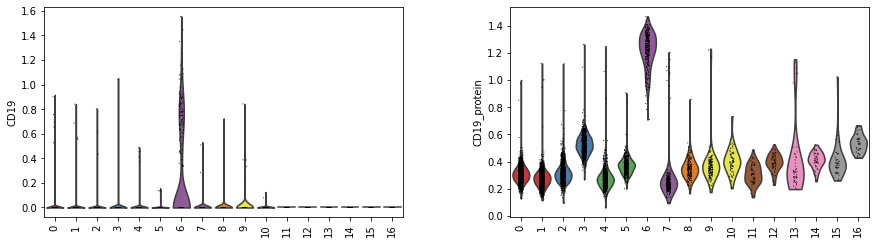

In [22]:
# Plot violin plots of CD19 gene expression (left) or protein abundance (right) in each cluster
sc.pl.violin(adata_cbmc_rna, keys=['CD19', 'CD19_protein'], groupby='rna_leiden', rotation=90)

Text(0.5, 1.0, 'CD19 Protein vs RNA raw counts ($r^{2} =-0.20$)')

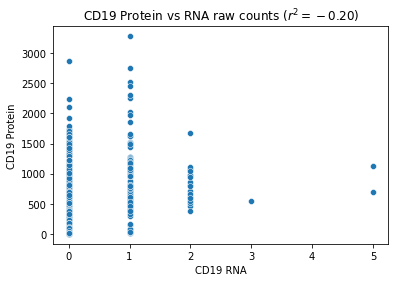

In [26]:
# plot CD19 protein vs RNA raw counts. Many cells have measurable CD19 protein despite having zero measurable CD19 RNA
sns.scatterplot(x=cbmc_rna['CD19'], y=cbmc_adt['CD19'])
plt.xlabel('CD19 RNA')
plt.ylabel('CD19 Protein')
plt.title('CD19 Protein vs RNA raw counts ($r^{2} =%0.2f$)' % (r2_score(cbmc_adt['CD19'], cbmc_rna['CD19'])))

## Predicting protein amount from gene expression
In the examples below, we use two machine learning methods, LightGBM and a multilayer perceptron, to predict protein amount from RNA gene expression.

In [22]:
# set up parameters for LightGBM models
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [23]:
# a separate LightGBM model needs to be trained for each of the 13 proteins
gbm_models = []

for i in trange(n_proteins):
    lgb_train = lgb.Dataset(adata_cbmc_rna.X[:6000, :], adata_cbmc_adt.X[:6000, i])
    lgb_eval = lgb.Dataset(adata_cbmc_rna.X[6000:, :], adata_cbmc_adt.X[6000:, i])
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=200,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    gbm_models.append(gbm)

  0%|          | 0/13 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.401128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 0.17414	valid_0's l1: 0.404386
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.158976	valid_0's l1: 0.385483
[3]	valid_0's l2: 0.145302	valid_0's l1: 0.367474
[4]	valid_0's l2: 0.132696	valid_0's l1: 0.350206
[5]	valid_0's l2: 0.121635	valid_0's l1: 0.334052
[6]	valid_0's l2: 0.111399	valid_0's l1: 0.31865
[7]	valid_0's l2: 0.102024	valid_0's l1: 0.303791
[8]	valid_0's l2: 0.0936474	valid_0's l1: 0.289942
[9]	valid_0's l2: 0.0860372	valid_0's l1: 0.276728
[10]	valid_0's l2: 0.0789586	valid_0's l1: 0.263833
[11]	valid_0's l2: 0.0727371	valid_0's l1: 0.251987
[12]	valid_0's l2: 0.0669432	valid_0's l1: 0.240437
[13]	valid_0's l2: 0.0617256	valid_0's l1: 0.229569
[14]	valid_0's l2: 0.0571245	valid_0's l1: 0.219431
[15]	valid_0's l2: 0.0528113	valid_0's l1: 0.209609
[16]	valid_0'

[49]	valid_0's l2: 0.0196555	valid_0's l1: 0.0982697
[50]	valid_0's l2: 0.0194903	valid_0's l1: 0.0974759
[51]	valid_0's l2: 0.0193441	valid_0's l1: 0.0966623
[52]	valid_0's l2: 0.0191815	valid_0's l1: 0.0958877
[53]	valid_0's l2: 0.0190549	valid_0's l1: 0.0951841
[54]	valid_0's l2: 0.018942	valid_0's l1: 0.0945856
[55]	valid_0's l2: 0.0188258	valid_0's l1: 0.0939813
[56]	valid_0's l2: 0.0186949	valid_0's l1: 0.0934226
[57]	valid_0's l2: 0.0185827	valid_0's l1: 0.0929604
[58]	valid_0's l2: 0.0185041	valid_0's l1: 0.0925829
[59]	valid_0's l2: 0.0184224	valid_0's l1: 0.0923167
[60]	valid_0's l2: 0.018347	valid_0's l1: 0.0920225
[61]	valid_0's l2: 0.0182599	valid_0's l1: 0.0916131
[62]	valid_0's l2: 0.0181957	valid_0's l1: 0.091307
[63]	valid_0's l2: 0.0181161	valid_0's l1: 0.0909581
[64]	valid_0's l2: 0.0180406	valid_0's l1: 0.0906067
[65]	valid_0's l2: 0.0179625	valid_0's l1: 0.0903462
[66]	valid_0's l2: 0.0179051	valid_0's l1: 0.0900963
[67]	valid_0's l2: 0.0178383	valid_0's l1: 0.0898

[61]	valid_0's l2: 0.0126013	valid_0's l1: 0.0835297
[62]	valid_0's l2: 0.0125923	valid_0's l1: 0.0834867
[63]	valid_0's l2: 0.0126059	valid_0's l1: 0.0836248
[64]	valid_0's l2: 0.012615	valid_0's l1: 0.0836896
[65]	valid_0's l2: 0.012614	valid_0's l1: 0.0837323
[66]	valid_0's l2: 0.0126027	valid_0's l1: 0.083689
[67]	valid_0's l2: 0.0126003	valid_0's l1: 0.0836894
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0125923	valid_0's l1: 0.0834867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 0.0376887	valid_0's l1: 0.138019
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.034803	valid_0's l1: 0.132969
[3]	valid_0's l2: 0.0321837	valid_0's l1: 0.128227
[4]	valid_0's l2: 0.0296958	valid_0's l1: 0.123532
[5]	valid_0's l2: 0.0275174	valid_0's l1: 0.119261
[6]	valid_0's l2: 0.0254662	valid_0's l1: 0.115056
[7]	valid_0's 

[60]	valid_0's l2: 0.00469786	valid_0's l1: 0.0527289
[61]	valid_0's l2: 0.00469652	valid_0's l1: 0.0527112
[62]	valid_0's l2: 0.00469001	valid_0's l1: 0.0526796
[63]	valid_0's l2: 0.0046837	valid_0's l1: 0.0526645
[64]	valid_0's l2: 0.004684	valid_0's l1: 0.0526537
[65]	valid_0's l2: 0.00468167	valid_0's l1: 0.0526372
[66]	valid_0's l2: 0.00468244	valid_0's l1: 0.0526615
[67]	valid_0's l2: 0.00467889	valid_0's l1: 0.0526372
[68]	valid_0's l2: 0.0046773	valid_0's l1: 0.052636
[69]	valid_0's l2: 0.00467518	valid_0's l1: 0.0526221
[70]	valid_0's l2: 0.00467681	valid_0's l1: 0.0526328
[71]	valid_0's l2: 0.00467437	valid_0's l1: 0.0526076
[72]	valid_0's l2: 0.00467182	valid_0's l1: 0.0525893
[73]	valid_0's l2: 0.00467041	valid_0's l1: 0.0525774
[74]	valid_0's l2: 0.00466529	valid_0's l1: 0.052543
[75]	valid_0's l2: 0.00466608	valid_0's l1: 0.0525483
[76]	valid_0's l2: 0.00466241	valid_0's l1: 0.0525353
[77]	valid_0's l2: 0.00467017	valid_0's l1: 0.0525636
[78]	valid_0's l2: 0.0046702	valid

[20]	valid_0's l2: 0.0214226	valid_0's l1: 0.123962
[21]	valid_0's l2: 0.0203837	valid_0's l1: 0.120648
[22]	valid_0's l2: 0.0194542	valid_0's l1: 0.117592
[23]	valid_0's l2: 0.0186038	valid_0's l1: 0.114734
[24]	valid_0's l2: 0.0178533	valid_0's l1: 0.112059
[25]	valid_0's l2: 0.0171323	valid_0's l1: 0.109488
[26]	valid_0's l2: 0.0165253	valid_0's l1: 0.107136
[27]	valid_0's l2: 0.0159644	valid_0's l1: 0.104942
[28]	valid_0's l2: 0.0155143	valid_0's l1: 0.103148
[29]	valid_0's l2: 0.0150853	valid_0's l1: 0.101402
[30]	valid_0's l2: 0.0145932	valid_0's l1: 0.0993546
[31]	valid_0's l2: 0.0142144	valid_0's l1: 0.097762
[32]	valid_0's l2: 0.0138585	valid_0's l1: 0.0962381
[33]	valid_0's l2: 0.0134694	valid_0's l1: 0.0945313
[34]	valid_0's l2: 0.0131587	valid_0's l1: 0.0932165
[35]	valid_0's l2: 0.0128563	valid_0's l1: 0.0918982
[36]	valid_0's l2: 0.0125885	valid_0's l1: 0.0907104
[37]	valid_0's l2: 0.0123543	valid_0's l1: 0.0896087
[38]	valid_0's l2: 0.0121442	valid_0's l1: 0.0886401
[39]

[51]	valid_0's l2: 0.00620843	valid_0's l1: 0.0569709
[52]	valid_0's l2: 0.00617476	valid_0's l1: 0.0568467
[53]	valid_0's l2: 0.00614442	valid_0's l1: 0.0566998
[54]	valid_0's l2: 0.00611388	valid_0's l1: 0.0565951
[55]	valid_0's l2: 0.00609123	valid_0's l1: 0.0564988
[56]	valid_0's l2: 0.00607765	valid_0's l1: 0.056461
[57]	valid_0's l2: 0.00606057	valid_0's l1: 0.0564207
[58]	valid_0's l2: 0.00604799	valid_0's l1: 0.056368
[59]	valid_0's l2: 0.00603195	valid_0's l1: 0.0563464
[60]	valid_0's l2: 0.00601463	valid_0's l1: 0.0562947
[61]	valid_0's l2: 0.00600218	valid_0's l1: 0.0562553
[62]	valid_0's l2: 0.00598935	valid_0's l1: 0.0562312
[63]	valid_0's l2: 0.00597935	valid_0's l1: 0.0561785
[64]	valid_0's l2: 0.00595955	valid_0's l1: 0.056102
[65]	valid_0's l2: 0.00595154	valid_0's l1: 0.056063
[66]	valid_0's l2: 0.00594134	valid_0's l1: 0.0560065
[67]	valid_0's l2: 0.00592097	valid_0's l1: 0.0559235
[68]	valid_0's l2: 0.00590411	valid_0's l1: 0.0558687
[69]	valid_0's l2: 0.00588651	va

Text(0.5, 1.0, '$r^{2} =0.93$')

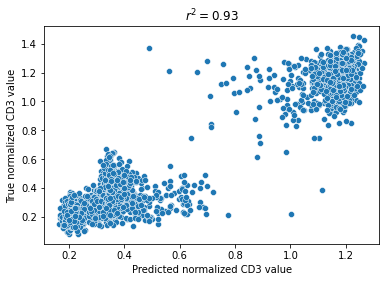

In [50]:
# evaluate the performance of the CD3 LightGBM model on the held out set
y_pred_gbm = gbm_models[0].predict(adata_cbmc_rna.X[6000:], num_iteration=gbm_models[0].best_iteration)
sns.scatterplot(x=y_pred_gbm, y=adata_cbmc_adt.X[6000:, 0])
plt.xlabel('Predicted normalized CD3 value')
plt.ylabel('True normalized CD3 value')
plt.title('Evaluating LightGBM ($r^{2} =%0.2f$)' % (r2_score(adata_cbmc_adt.X[6000:, 0], y_pred_gbm)))

In [ ]:
# build and compile a keras MLP to predict proteins from RNA in a multitask fashion
mlp_model = tf.keras.models.Sequential()
mlp_model.add(tf.keras.layers.Dense(1024, input_shape=(adata_cbmc_rna.shape[1],), activation='relu'))
mlp_model.add(tf.keras.layers.Dense(256, activation='relu'))
mlp_model.add(tf.keras.layers.Dense(n_proteins, activation='relu'))
mlp_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [47]:
# train MLP model
mlp_model.fit(adata_cbmc_rna.X[:6000, :], adata_cbmc_adt.X[:6000, :], epochs=30, batch_size=32, verbose=1, validation_data=(adata_cbmc_rna.X[6000:, :], adata_cbmc_adt.X[6000:, :]))

Epoch 1/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0854 - mse: 0.0854 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 3/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 4/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 5/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 6/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 7/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 8/30
188/188 [==============================] - 1s 4ms/step - loss: 0.

Text(0.5, 1.0, '$r^{2} =0.91$')

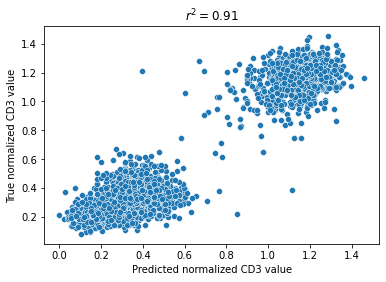

In [51]:
# evaluate the performance of the MLP model for CD3 on the held out set
y_pred_mlp = mlp_model.predict(adata_cbmc_rna.X[6000:])[:,0]
sns.scatterplot(x=y_pred_mlp, y=adata_cbmc_adt.X[6000:, 0])
plt.xlabel('Predicted normalized CD3 value')
plt.ylabel('True normalized CD3 value')
plt.title('Evaluating multilayer perceptron ($r^{2} =%0.2f$)' % (r2_score(adata_cbmc_adt.X[6000:, 0], y_pred_mlp)))